## Our Task

In this project, we are going to try to create a GAN that will generate CIFAR-10 imgaes(32 * 32) with 3 channels(RGB) that can fool even the best classifiers(and humans too of course). Here's what we are going to realize:
 - Real CIFAR-10 training images
 - A generator network that takes in a random noise vector and produces a synthetic image
 - A discriminator network (a CNN) that learns to distinguish between real and synthetic images. You can think of it as just a binary classifier (1 for real image, 0 for fake)
 - An optimization procedure that jointly updates both networks through SGD. This is the tricky part as we need to train the generator network to fool the discriminator network, which means that we have unique gradient flows and labels.
 - Tensorflow - Our choice of Deep Learning framework

In [1]:
import tensorflow as tf
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Loading CIFAR-10 data

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
        
    return dict

cifar = unpickle('./cifar-10-python/cifar-10-batches-py/data_batch_1')
x_train = cifar[b'data']
print(x_train)
x_train.shape

[[ 59  43  50 ..., 140  84  72]
 [154 126 105 ..., 139 142 144]
 [255 253 253 ...,  83  83  84]
 ..., 
 [ 71  60  74 ...,  68  69  68]
 [250 254 211 ..., 215 255 254]
 [ 62  61  60 ..., 130 130 131]]


(10000, 3072)

 - Let's look at what a random image might look like :
     we need to reshape the data to be size of 32 * 32 * 3

(32, 32, 3)


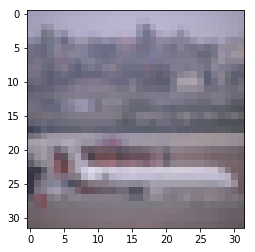

In [5]:
randomNum = random.randint(0,10000)
image = np.zeros([32,32,3])
for i in range(3):
    image[:,:,i] = x_train[randomNum,1024*i:1024*(i+1)].reshape([32,32,])
print(image.shape)
plt.imshow(image/255)
plt.show()

(10000, 32, 32, 3)


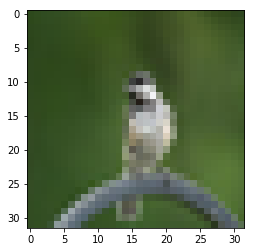

In [4]:
x_train_reshape = np.zeros([x_train.shape[0], 32, 32, 3])
for i in range(x_train.shape[0]):
    for j in range(3):
        x_train_reshape[i, :, :, j] = x_train[i, 1024*j : 1024*(j+1)].reshape([32,32,])

print(x_train_reshape.shape)
plt.imshow(x_train_reshape[54]/255)

## Discriminator Network

 - 
In order to do that, let's first define some functions that will help us with creating CNNs in Tensorflow

In [6]:
def conv2d(x, W):
  return tf.nn.conv2d(input=x, filter=W, strides=[1, 1, 1, 1], padding='SAME')

def avg_pool_2x2(x):
  return tf.nn.avg_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [7]:
def discriminator(x_image, reuse=False):
    with tf.variable_scope('discriminator') as scope:
        if (reuse):
            tf.get_variable_scope().reuse_variables()
        #First Conv and Pool Layers
        W_conv1 = tf.get_variable('d_wconv1', [5, 5, 3, 8], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_conv1 = tf.get_variable('d_bconv1', [8], initializer=tf.constant_initializer(0))
        h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
        h_pool1 = avg_pool_2x2(h_conv1)

        #Second Conv and Pool Layers
        W_conv2 = tf.get_variable('d_wconv2', [5, 5, 8, 16], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_conv2 = tf.get_variable('d_bconv2', [16], initializer=tf.constant_initializer(0))
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
        h_pool2 = avg_pool_2x2(h_conv2)

        #First Fully Connected Layer
        W_fc1 = tf.get_variable('d_wfc1', [8 * 8 * 16, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_fc1 = tf.get_variable('d_bfc1', [32], initializer=tf.constant_initializer(0))
        h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*16])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

        #Second Fully Connected Layer
        W_fc2 = tf.get_variable('d_wfc2', [32, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_fc2 = tf.get_variable('d_bfc2', [1], initializer=tf.constant_initializer(0))

        #Final Layer
        y_conv=(tf.matmul(h_fc1, W_fc2) + b_fc2)
    return y_conv

## Generator Network

In [8]:
def generator(z, batch_size, z_dim, reuse=False):
    with tf.variable_scope('generator') as scope:
        if (reuse):
            tf.get_variable_scope().reuse_variables()
        g_dim = 64 #Number of filters of first layer of generator 
        c_dim = 3 #Color dimension of output (CIFAR is RGB, so c_dim = 3 for us)
        s = 32 #Output size of the image
        s2, s4, s8, s16 = int(s/2), int(s/4), int(s/8), int(s/16) #We want to slowly upscale the image, so these values will help
                                                                  #make that change gradual.

        h0 = tf.reshape(z, [batch_size, s16, s16, 25])
        h0 = tf.nn.relu(h0)
        #Dimensions of h0 = batch_size x 2 x 2 x 25

        #First DeConv Layer
        output1_shape = [batch_size, s8, s8, g_dim*4]
        W_conv1 = tf.get_variable('g_wconv1', [5, 5, output1_shape[-1], int(h0.get_shape()[-1])], 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv1 = tf.get_variable('g_bconv1', [output1_shape[-1]], initializer=tf.constant_initializer(.1))
        H_conv1 = tf.nn.conv2d_transpose(h0, W_conv1, output_shape=output1_shape, 
                                         strides=[1, 2, 2, 1], padding='SAME') + b_conv1
        H_conv1 = tf.contrib.layers.batch_norm(inputs = H_conv1, center=True, scale=True, is_training=True, scope="g_bn1")
        H_conv1 = tf.nn.relu(H_conv1)
        #Dimensions of H_conv1 = batch_size x 4 x 4 x 256

        #Second DeConv Layer
        output2_shape = [batch_size, s4, s4, g_dim*2]
        W_conv2 = tf.get_variable('g_wconv2', [5, 5, output2_shape[-1], int(H_conv1.get_shape()[-1])], 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv2 = tf.get_variable('g_bconv2', [output2_shape[-1]], initializer=tf.constant_initializer(.1))
        H_conv2 = tf.nn.conv2d_transpose(H_conv1, W_conv2, output_shape=output2_shape, 
                                         strides=[1, 2, 2, 1], padding='SAME') + b_conv2
        H_conv2 = tf.contrib.layers.batch_norm(inputs = H_conv2, center=True, scale=True, is_training=True, scope="g_bn2")
        H_conv2 = tf.nn.relu(H_conv2)
        #Dimensions of H_conv2 = batch_size x 8 x 8 x 128

        #Third DeConv Layer
        output3_shape = [batch_size, s2, s2, g_dim*1]
        W_conv3 = tf.get_variable('g_wconv3', [5, 5, output3_shape[-1], int(H_conv2.get_shape()[-1])], 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv3 = tf.get_variable('g_bconv3', [output3_shape[-1]], initializer=tf.constant_initializer(.1))
        H_conv3 = tf.nn.conv2d_transpose(H_conv2, W_conv3, output_shape=output3_shape, 
                                         strides=[1, 2, 2, 1], padding='SAME') + b_conv3
        H_conv3 = tf.contrib.layers.batch_norm(inputs = H_conv3, center=True, scale=True, is_training=True, scope="g_bn3")
        H_conv3 = tf.nn.relu(H_conv3)
        #Dimensions of H_conv3 = batch_size x 16 x 16 x 64

        #Fourth DeConv Layer
        output4_shape = [batch_size, s, s, c_dim]
        W_conv4 = tf.get_variable('g_wconv4', [5, 5, output4_shape[-1], int(H_conv3.get_shape()[-1])], 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv4 = tf.get_variable('g_bconv4', [output4_shape[-1]], initializer=tf.constant_initializer(.1))
        H_conv4 = tf.nn.conv2d_transpose(H_conv3, W_conv4, output_shape=output4_shape, 
                                         strides=[1, 2, 2, 1], padding='SAME') + b_conv4
        H_conv4 = tf.nn.sigmoid(H_conv4)
        #Dimensions of H_conv4 = batch_size x 32 x 32 x 1

    return H_conv4

## Generating a Sample Image

(32, 32, 3)


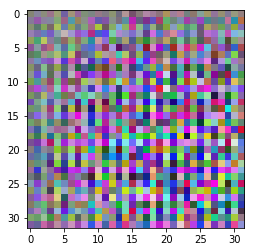

In [10]:
z_dimensions = 100
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])

generated_image_output = generator(z_placeholder, 1, z_dimensions)
z_batch = np.random.normal(0, 1, [1, z_dimensions])

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    generated_image = sess.run(generated_image_output,
                                feed_dict={z_placeholder: z_batch})
    generated_image = generated_image.reshape([32,32,3])
    print(generated_image.shape)
    plt.imshow(generated_image)
    
    
# sess.run(tf.global_variables_initializer())
# temp = (sess.run(sample_image, feed_dict={z_test_placeholder: test_z}))

# my_i = temp.squeeze()
# print(my_i.shape)
# plt.imshow(my_i)
# plt.show()

## Training a GAN

In [66]:
batch_size = 50
tf.reset_default_graph() #Since we changed our batch size (from 1 to 16), we need to reset our Tensorflow graph

sess = tf.Session()
x_placeholder = tf.placeholder(tf.float32, shape = [None,32,32,3], name='x_placeholder') #Placeholder for input images to the discriminator
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions], name='z_placeholder') #Placeholder for input noise vectors to the generator

Dx = discriminator(x_placeholder) #Dx will hold discriminator prediction probabilities for the real CIFAR images
Gz = generator(z_placeholder, batch_size, z_dimensions) #Gz holds the generated images
Dg = discriminator(Gz, reuse=True) #Dg will hold discriminator prediction probabilities for generated images

g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.ones_like(Dg))) # ensure forward compatibility: function needs to have logits and labels args explicitly used

d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dx, labels = tf.ones_like(Dx)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.zeros_like(Dg)))

tvars = tf.trainable_variables()
d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

print([v.name for v in d_vars])
print([v.name for v in g_vars])

# Train the discriminator
d_trainer_fake = tf.train.AdamOptimizer(0.00002).minimize(d_loss_fake, var_list=d_vars)
d_trainer_real = tf.train.AdamOptimizer(0.00002).minimize(d_loss_real, var_list=d_vars)

# Train the generator
g_trainer = tf.train.AdamOptimizer(0.0007).minimize(g_loss, var_list=g_vars)

['discriminator/d_wconv1:0', 'discriminator/d_bconv1:0', 'discriminator/d_wconv2:0', 'discriminator/d_bconv2:0', 'discriminator/d_wfc1:0', 'discriminator/d_bfc1:0', 'discriminator/d_wfc2:0', 'discriminator/d_bfc2:0']
['generator/g_wconv1:0', 'generator/g_bconv1:0', 'generator/g_bn1/beta:0', 'generator/g_bn1/gamma:0', 'generator/g_wconv2:0', 'generator/g_bconv2:0', 'generator/g_bn2/beta:0', 'generator/g_bn2/gamma:0', 'generator/g_wconv3:0', 'generator/g_bconv3:0', 'generator/g_bn3/beta:0', 'generator/g_bn3/gamma:0', 'generator/g_wconv4:0', 'generator/g_bconv4:0']


In [67]:
import datetime
tf.summary.scalar('Generator_loss', g_loss)
tf.summary.scalar('Discriminator_loss_real', d_loss_real)
tf.summary.scalar('Discriminator_loss_fake', d_loss_fake)

images_for_tensorboard = generator(z_placeholder, batch_size, z_dimensions,reuse=True)
tf.summary.image('Generated_images', images_for_tensorboard, 5)
merged = tf.summary.merge_all()
logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
writer = tf.summary.FileWriter(logdir, sess.graph)

dLossReal: 0.670995 dLossFake: 0.693292
dLossReal: 0.667152 dLossFake: 0.693259
dLossReal: 0.66548 dLossFake: 0.693226
Iteration: 0 at 2018-04-16 00:49:02.175294


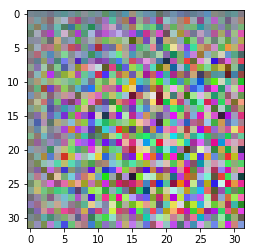

Estimate: [[-0.00011677]]
0.669136 0.693124
Iteration: 100 at 2018-04-16 00:50:05.570166


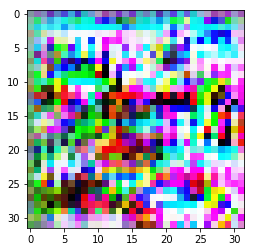

Estimate: [[ 0.00096169]]
0.663657 0.69365
Iteration: 200 at 2018-04-16 00:51:06.553608


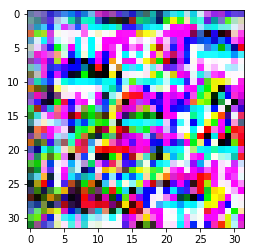

Estimate: [[ 0.00050261]]
0.67956 0.693419
Iteration: 300 at 2018-04-16 00:52:09.306210


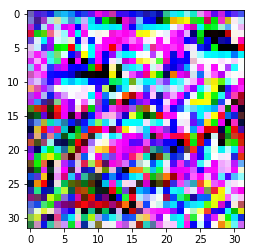

Estimate: [[ 0.00026823]]
0.688602 0.693297
Iteration: 400 at 2018-04-16 00:53:12.566872


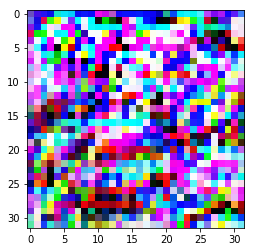

Estimate: [[ 0.00014531]]
0.693138 0.693235
Iteration: 500 at 2018-04-16 00:54:16.983531


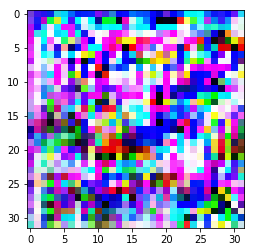

Estimate: [[  8.54510436e-05]]
0.693972 0.693204
Iteration: 600 at 2018-04-16 00:55:21.645329


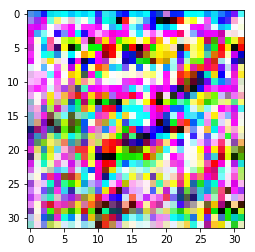

Estimate: [[  4.86976824e-05]]
0.691649 0.693186
Iteration: 700 at 2018-04-16 00:56:27.461702


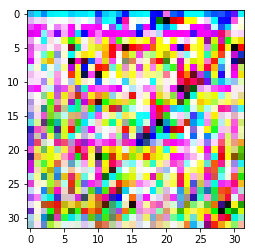

Estimate: [[ -6.80707162e-05]]
0.69264 0.693128
Iteration: 800 at 2018-04-16 00:57:34.412417


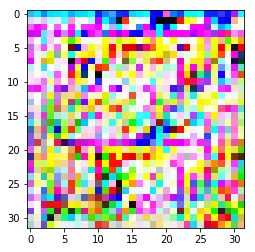

Estimate: [[-0.0001871]]
0.692998 0.693068
Iteration: 900 at 2018-04-16 00:58:42.188224


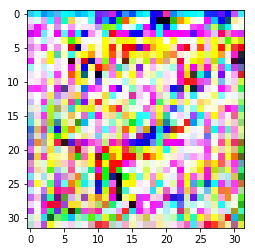

Estimate: [[-0.00033943]]
0.693456 0.692995
Iteration: 1000 at 2018-04-16 01:00:28.247703


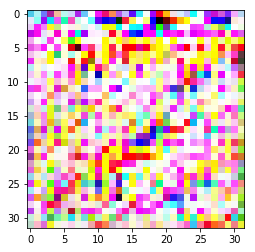

Estimate: [[-0.00057691]]
0.69384 0.692879
Iteration: 1100 at 2018-04-16 01:01:40.250357


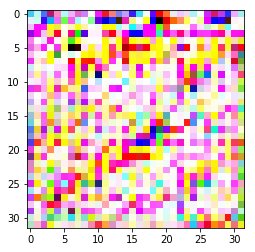

Estimate: [[-0.00075756]]
0.693913 0.69279
Iteration: 1200 at 2018-04-16 01:02:51.602585


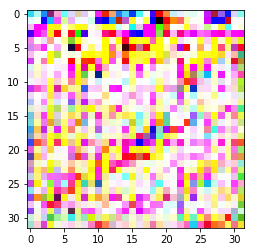

Estimate: [[-0.00089083]]
0.693948 0.692725
Iteration: 1300 at 2018-04-16 01:04:03.773829


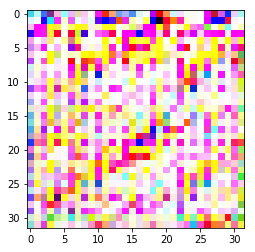

Estimate: [[-0.00103138]]
0.693922 0.692656
Iteration: 1400 at 2018-04-16 01:05:16.458849


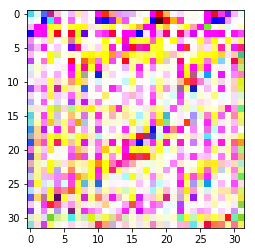

Estimate: [[-0.00119249]]
0.693721 0.692577
Iteration: 1500 at 2018-04-16 01:06:30.412835


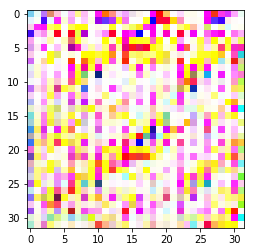

Estimate: [[-0.00137152]]
0.693894 0.692491
Iteration: 1600 at 2018-04-16 01:07:45.511940


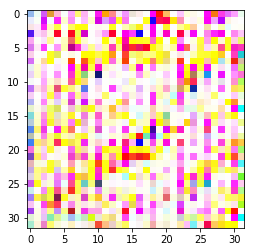

Estimate: [[-0.00146444]]
0.693939 0.692445
Iteration: 1700 at 2018-04-16 01:09:01.125316


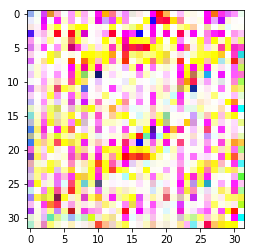

Estimate: [[-0.00161307]]
0.694115 0.692373
Iteration: 1800 at 2018-04-16 01:10:18.555285


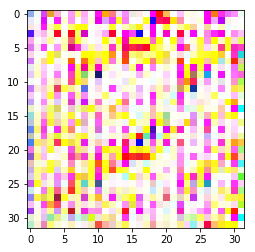

Estimate: [[-0.00177208]]
0.694155 0.692295
Iteration: 1900 at 2018-04-16 01:24:56.732451


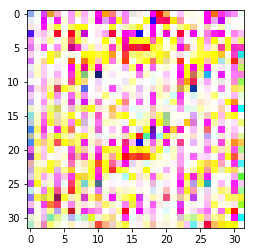

Estimate: [[-0.00197444]]
0.694307 0.692196
Iteration: 2000 at 2018-04-16 01:26:19.169640


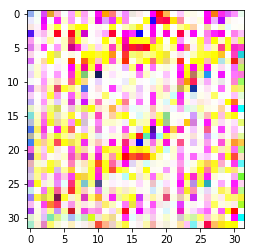

Estimate: [[-0.00217402]]
0.694384 0.692098
Iteration: 2100 at 2018-04-16 01:27:39.350508


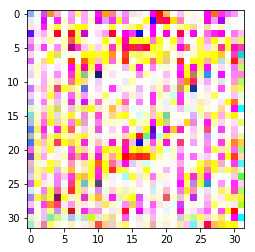

Estimate: [[-0.00241367]]
0.694533 0.691981
Iteration: 2200 at 2018-04-16 01:29:00.415683


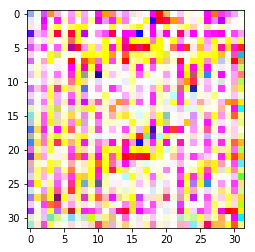

Estimate: [[-0.00266282]]
0.694649 0.691857
Iteration: 2300 at 2018-04-16 01:30:22.955946


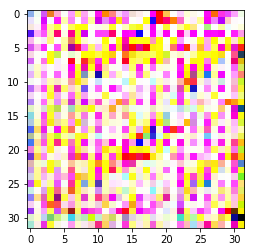

Estimate: [[-0.00301774]]
0.694759 0.691683
Iteration: 2400 at 2018-04-16 01:31:46.422660


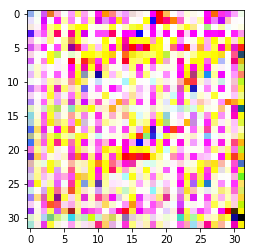

Estimate: [[-0.0035982]]
0.695024 0.691396
Iteration: 2500 at 2018-04-16 01:33:10.295565


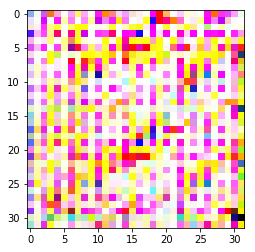

Estimate: [[-0.00441957]]
0.695432 0.690992
Iteration: 2600 at 2018-04-16 01:34:35.377717


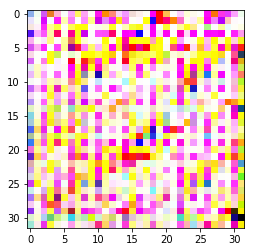

Estimate: [[-0.00523289]]
0.695822 0.690592
Iteration: 2700 at 2018-04-16 01:36:01.379542


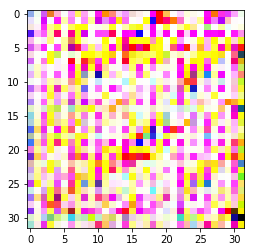

Estimate: [[-0.00612364]]
0.696274 0.690154
Iteration: 2800 at 2018-04-16 02:30:41.536131


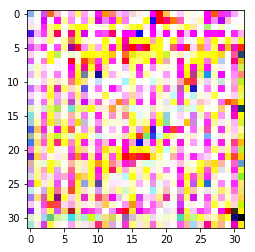

Estimate: [[-0.00693145]]
0.69666 0.689756
Iteration: 2900 at 2018-04-16 02:36:48.962004


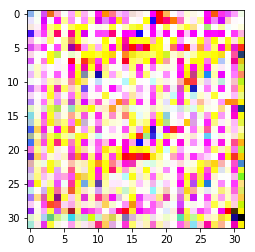

Estimate: [[-0.00779046]]
0.697096 0.689334
Iteration: 3000 at 2018-04-16 02:39:43.257044


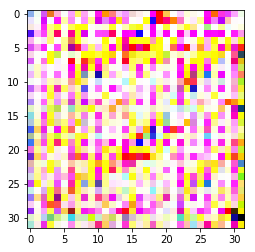

Estimate: [[-0.00853281]]
0.697457 0.688969
Iteration: 3100 at 2018-04-16 02:41:14.685593


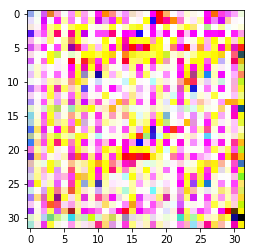

Estimate: [[-0.00932767]]
0.697856 0.688577
Iteration: 3200 at 2018-04-16 02:42:46.875146


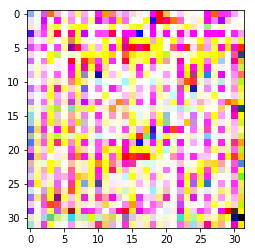

Estimate: [[-0.00999229]]
0.698186 0.68825
Iteration: 3300 at 2018-04-16 02:44:20.481448


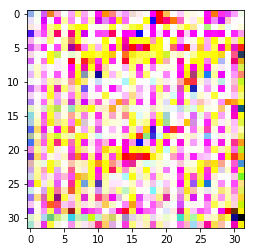

Estimate: [[-0.01072049]]
0.698546 0.687892
Iteration: 3400 at 2018-04-16 02:45:55.102301


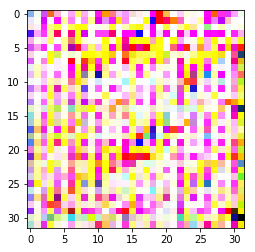

Estimate: [[-0.01131103]]
0.698845 0.687601
Iteration: 3500 at 2018-04-16 02:47:30.569600


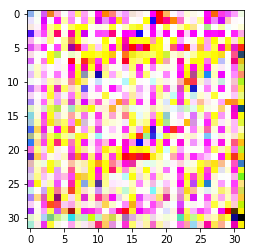

Estimate: [[-0.01197825]]
0.699171 0.687273
Iteration: 3600 at 2018-04-16 02:49:06.606195


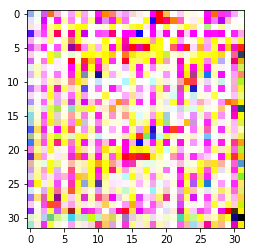

Estimate: [[-0.01250355]]
0.699441 0.687015
Iteration: 3700 at 2018-04-16 02:50:44.023534


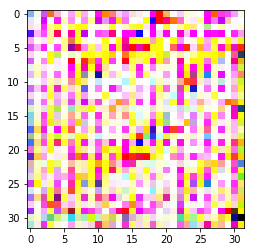

Estimate: [[-0.01311766]]
0.699738 0.686713
Iteration: 3800 at 2018-04-16 02:52:21.784324


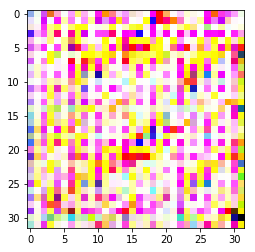

Estimate: [[-0.01359152]]
0.699983 0.686481
Iteration: 3900 at 2018-04-16 02:54:00.965174


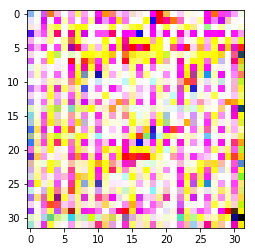

Estimate: [[-0.01417424]]
0.700267 0.686197
Iteration: 4000 at 2018-04-16 02:55:41.271774


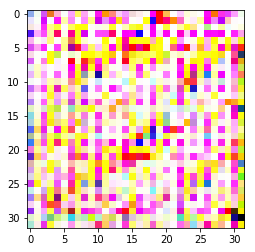

Estimate: [[-0.01460558]]
0.700488 0.685986
Iteration: 4100 at 2018-04-16 02:57:22.125230


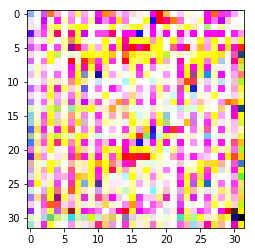

Estimate: [[-0.01514998]]
0.700757 0.685719
Iteration: 4200 at 2018-04-16 02:59:04.308352


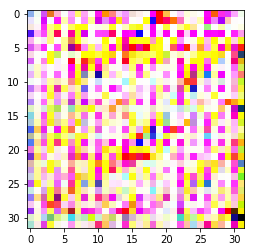

Estimate: [[-0.01553556]]
0.700951 0.68553
Iteration: 4300 at 2018-04-16 03:00:47.863495


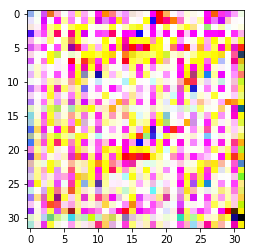

Estimate: [[-0.01604312]]
0.701207 0.685281
Iteration: 4400 at 2018-04-16 03:02:32.018509


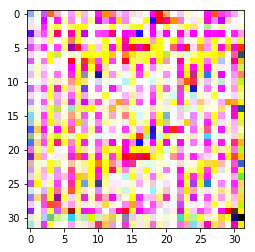

Estimate: [[-0.01638605]]
0.701378 0.685113
Iteration: 4500 at 2018-04-16 03:04:16.905036


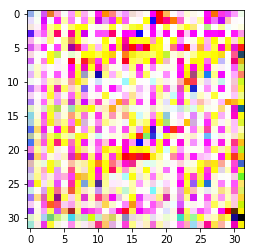

Estimate: [[-0.01685984]]
0.701617 0.684881
Iteration: 4600 at 2018-04-16 03:06:02.868797


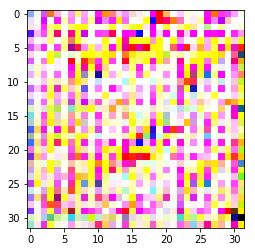

Estimate: [[-0.01716497]]
0.701769 0.684731
Iteration: 4700 at 2018-04-16 03:07:49.114783


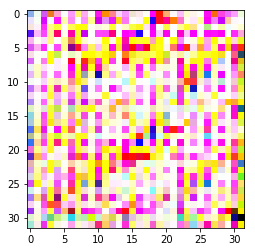

Estimate: [[-0.01760732]]
0.701993 0.684514
Iteration: 4800 at 2018-04-16 03:09:37.643624


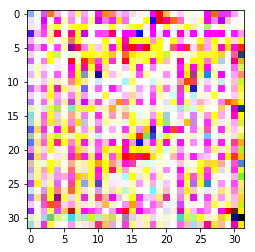

Estimate: [[-0.01787747]]
0.702127 0.684382
Iteration: 4900 at 2018-04-16 03:11:27.123357


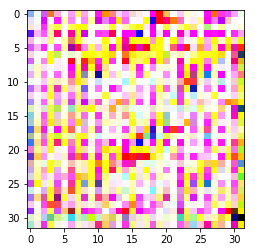

Estimate: [[-0.01829197]]
0.702338 0.684178
Iteration: 5000 at 2018-04-16 03:13:17.907658


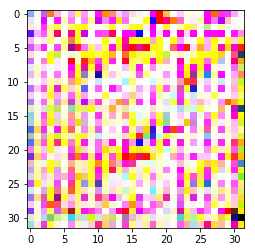

Estimate: [[-0.01853084]]
0.702455 0.684062
Iteration: 5100 at 2018-04-16 03:15:09.579662


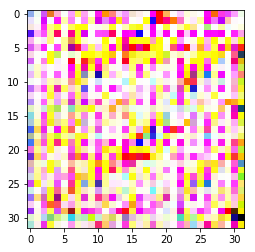

Estimate: [[-0.01891932]]
0.702654 0.683871
Iteration: 5200 at 2018-04-16 03:17:02.558768


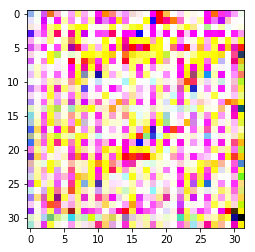

Estimate: [[-0.01912957]]
0.702755 0.683768
Iteration: 5300 at 2018-04-16 03:18:57.064733


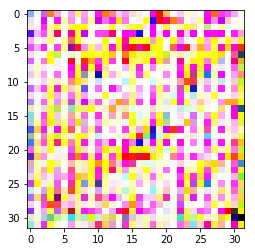

Estimate: [[-0.01949467]]
0.702944 0.683589
Iteration: 5400 at 2018-04-16 03:20:52.351598


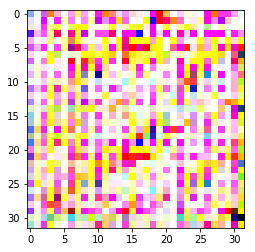

Estimate: [[-0.01967944]]
0.703032 0.683498
Iteration: 5500 at 2018-04-16 03:22:48.304353


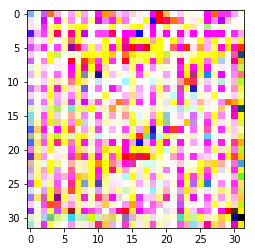

Estimate: [[-0.02002345]]
0.703211 0.683329
Iteration: 5600 at 2018-04-16 03:24:46.042042


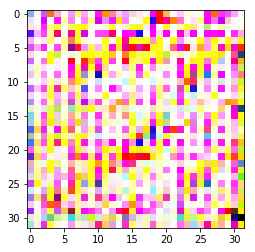

Estimate: [[-0.02018582]]
0.703286 0.68325
Iteration: 5700 at 2018-04-16 03:26:44.585589


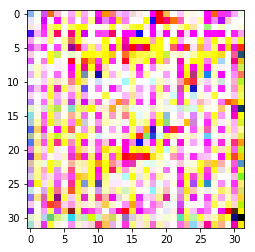

Estimate: [[-0.02051109]]
0.703457 0.68309
Iteration: 5800 at 2018-04-16 03:28:43.844378


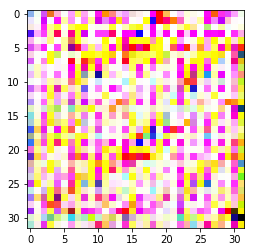

Estimate: [[-0.02065268]]
0.703521 0.683021
Iteration: 5900 at 2018-04-16 03:30:43.979373


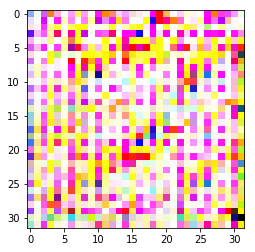

Estimate: [[-0.02096129]]
0.703684 0.68287
Iteration: 6000 at 2018-04-16 03:32:45.667713


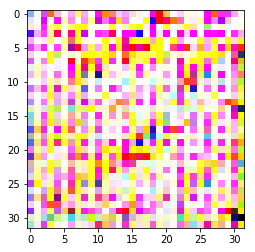

Estimate: [[-0.02108474]]
0.703737 0.682809
Iteration: 6100 at 2018-04-16 03:34:50.556400


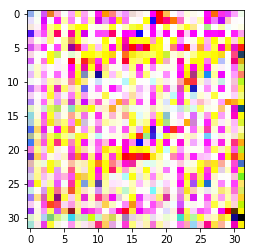

Estimate: [[-0.02137869]]
0.703895 0.682665
Iteration: 6200 at 2018-04-16 03:36:53.611428


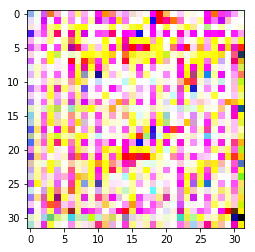

Estimate: [[-0.02148623]]
0.703939 0.682613
Iteration: 6300 at 2018-04-16 03:38:57.690873


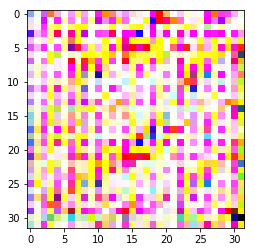

Estimate: [[-0.02176743]]
0.704091 0.682474
Iteration: 6400 at 2018-04-16 03:41:03.675141


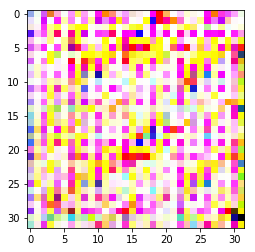

Estimate: [[-0.021861]]
0.704127 0.682429
Iteration: 6500 at 2018-04-16 03:43:10.311516


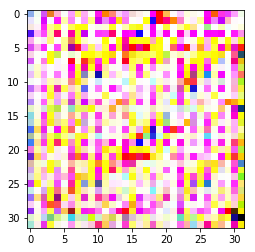

Estimate: [[-0.02213108]]
0.704275 0.682296
Iteration: 6600 at 2018-04-16 03:45:18.028867


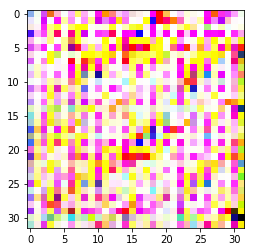

Estimate: [[-0.02221233]]
0.704303 0.682257
Iteration: 6700 at 2018-04-16 03:47:26.389118


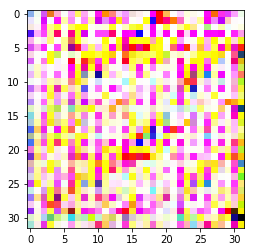

Estimate: [[-0.02247271]]
0.704447 0.682129
Iteration: 6800 at 2018-04-16 03:49:36.407933


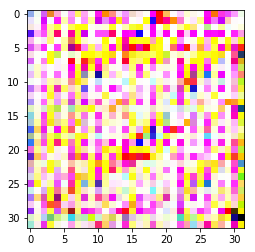

Estimate: [[-0.02254314]]
0.704469 0.682095
Iteration: 6900 at 2018-04-16 03:51:47.937985


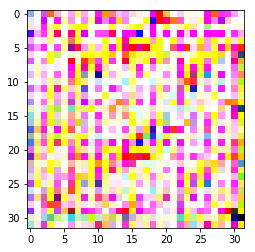

Estimate: [[-0.02279496]]
0.70461 0.681971
Iteration: 7000 at 2018-04-16 03:53:59.521726


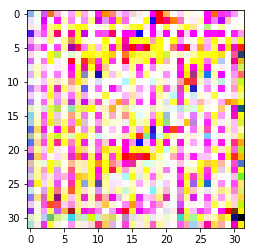

Estimate: [[-0.02285584]]
0.704627 0.681941
Iteration: 7100 at 2018-04-16 03:56:12.878864


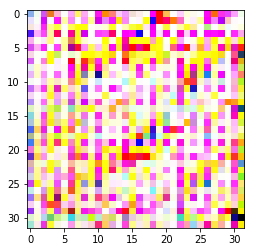

Estimate: [[-0.02310032]]
0.704764 0.681821
Iteration: 7200 at 2018-04-16 03:58:26.899892


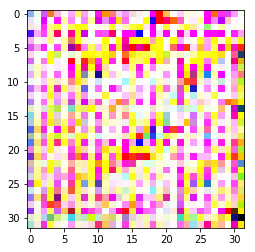

Estimate: [[-0.02315954]]
0.70478 0.681795
Iteration: 7300 at 2018-04-16 04:00:41.541083


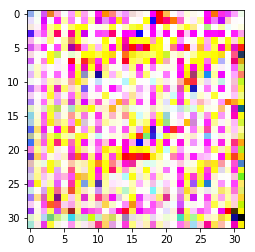

Estimate: [[-0.02341586]]
0.704923 0.681673
Iteration: 7400 at 2018-04-16 04:02:59.255433


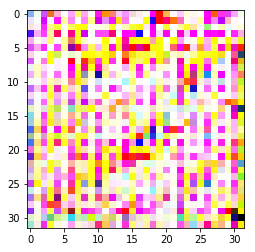

Estimate: [[-0.02347409]]
0.704938 0.681646
Iteration: 7500 at 2018-04-16 04:05:17.673256


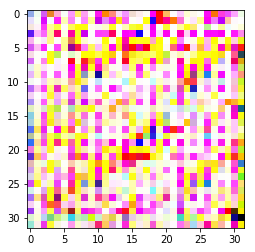

Estimate: [[-0.02372757]]
0.705081 0.681522
Iteration: 7600 at 2018-04-16 04:07:37.206195


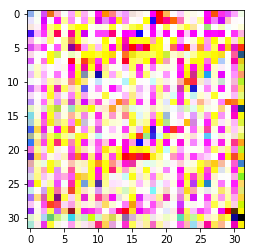

Estimate: [[-0.02377591]]
0.705091 0.681499
Iteration: 7700 at 2018-04-16 04:09:57.836747


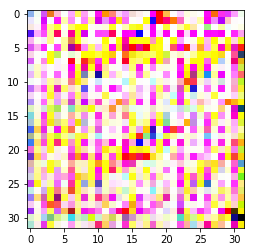

Estimate: [[-0.02402295]]
0.70523 0.681378
Iteration: 7800 at 2018-04-16 04:12:18.150645


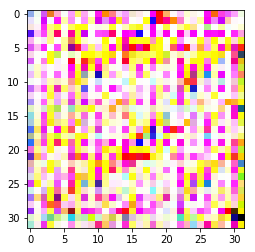

Estimate: [[-0.02406272]]
0.705235 0.681359
Iteration: 7900 at 2018-04-16 04:14:42.515195


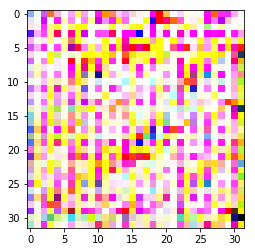

Estimate: [[-0.02430413]]
0.705371 0.681241
Iteration: 8000 at 2018-04-16 04:17:06.272102


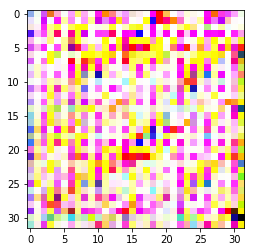

Estimate: [[-0.02433737]]
0.705374 0.681225
Iteration: 8100 at 2018-04-16 04:19:31.585704


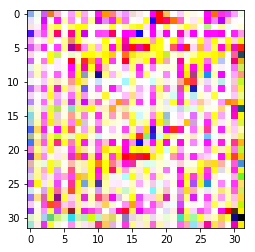

Estimate: [[-0.02457441]]
0.705507 0.681109
Iteration: 8200 at 2018-04-16 04:21:57.236945


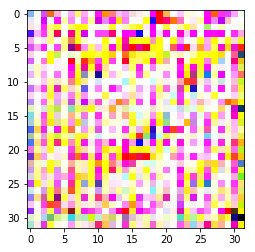

Estimate: [[-0.02460158]]
0.705508 0.681095
Iteration: 8300 at 2018-04-16 04:24:24.655172


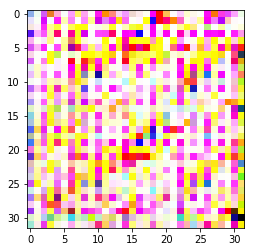

Estimate: [[-0.02483521]]
0.705638 0.680981
Iteration: 8400 at 2018-04-16 04:26:54.747188


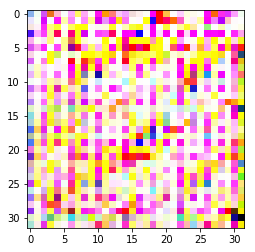

Estimate: [[-0.02485772]]
0.705637 0.68097
Iteration: 8500 at 2018-04-16 04:29:24.721794


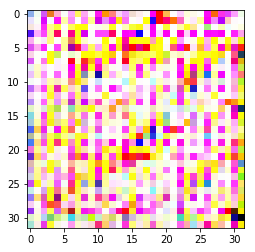

Estimate: [[-0.02508796]]
0.705765 0.680857
Iteration: 8600 at 2018-04-16 04:31:53.495086


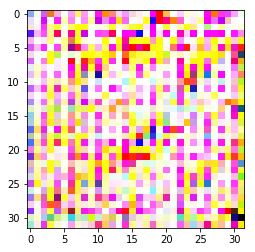

Estimate: [[-0.02510617]]
0.705762 0.680849
Iteration: 8700 at 2018-04-16 04:34:26.159345


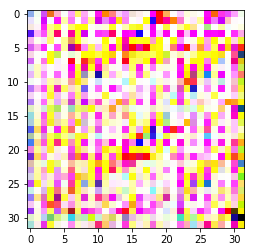

Estimate: [[-0.02522304]]
0.705826 0.680796
Iteration: 8800 at 2018-04-16 04:36:59.748890


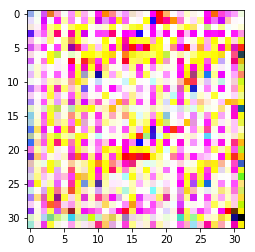

Estimate: [[-0.02513293]]
0.705773 0.680841
Iteration: 8900 at 2018-04-16 04:39:35.181825


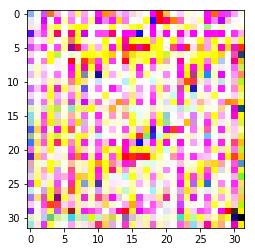

Estimate: [[-0.02530724]]
0.70586 0.680756
Iteration: 9000 at 2018-04-16 04:42:10.506288


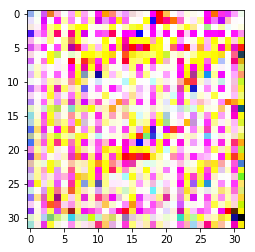

Estimate: [[-0.02528787]]
0.70585 0.680766
Iteration: 9100 at 2018-04-16 04:44:50.212406


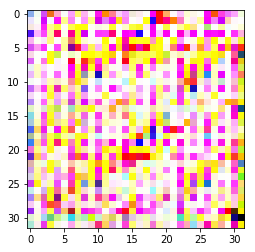

Estimate: [[-0.02551243]]
0.705958 0.680655
Iteration: 9200 at 2018-04-16 04:47:29.445337


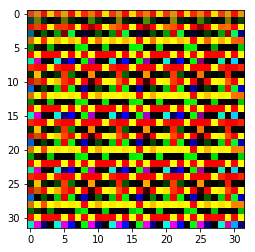

Estimate: [[-0.02359042]]
0.70457 0.681633
Iteration: 9300 at 2018-04-16 04:50:11.042138


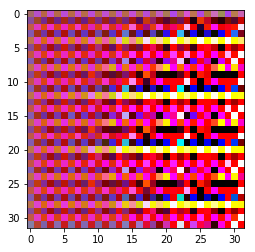

Estimate: [[-0.02252985]]
0.704484 0.682101
Iteration: 9400 at 2018-04-16 04:52:51.432224


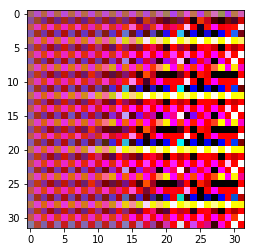

Estimate: [[-0.02276556]]
0.704605 0.681984
Iteration: 9500 at 2018-04-16 04:55:34.412386


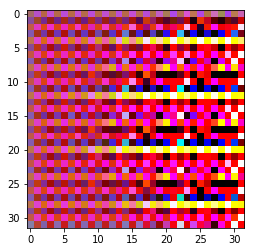

Estimate: [[-0.0231507]]
0.70479 0.681794
Iteration: 9600 at 2018-04-16 04:58:18.833167


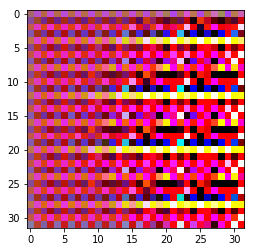

Estimate: [[-0.02332257]]
0.704878 0.681709
Iteration: 9700 at 2018-04-16 05:01:01.520939


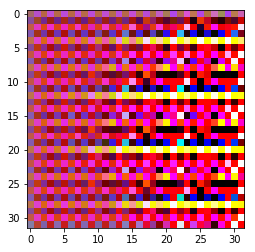

Estimate: [[-0.02365948]]
0.705045 0.681543
Iteration: 9800 at 2018-04-16 05:03:49.348626


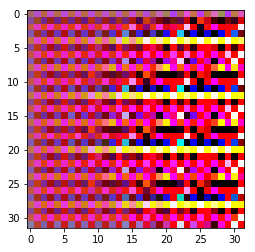

Estimate: [[-0.02380768]]
0.705117 0.68147
Iteration: 9900 at 2018-04-16 05:06:35.640067


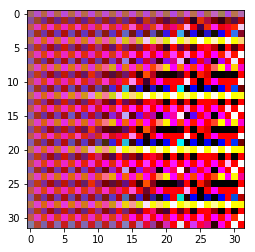

Estimate: [[-0.02411393]]
0.705273 0.681319
Iteration: 10000 at 2018-04-16 05:09:23.887671


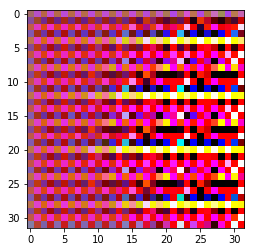

Estimate: [[-0.02421697]]
0.705322 0.681268
Iteration: 10100 at 2018-04-16 05:12:12.565607


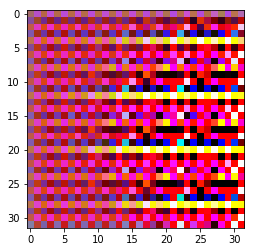

Estimate: [[-0.02448841]]
0.70546 0.681134
Iteration: 10200 at 2018-04-16 05:15:01.669857


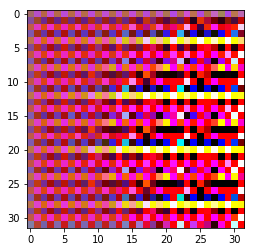

Estimate: [[-0.02456219]]
0.705494 0.681098
Iteration: 10300 at 2018-04-16 05:17:51.861719


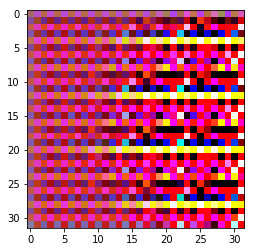

Estimate: [[-0.0248093]]
0.705619 0.680977
Iteration: 10400 at 2018-04-16 05:20:44.333554


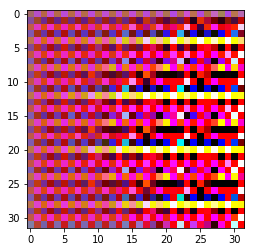

Estimate: [[-0.02486045]]
0.705643 0.680952
Iteration: 10500 at 2018-04-16 05:23:36.384478


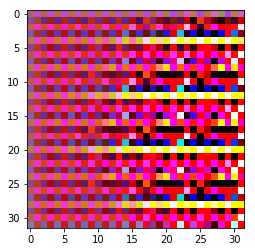

Estimate: [[-0.02508943]]
0.705757 0.680839
Iteration: 10600 at 2018-04-16 05:26:30.943242


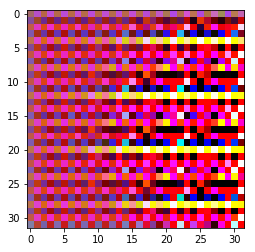

Estimate: [[-0.02512407]]
0.705775 0.680822
Iteration: 10700 at 2018-04-16 05:29:26.526348


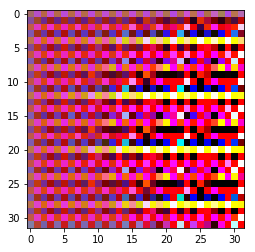

Estimate: [[-0.02533977]]
0.70588 0.680716
Iteration: 10800 at 2018-04-16 05:32:24.501464


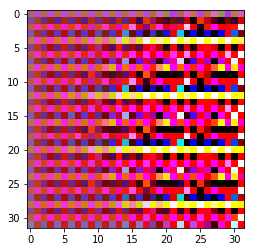

Estimate: [[-0.02536259]]
0.705895 0.680705
Iteration: 10900 at 2018-04-16 05:35:23.478599


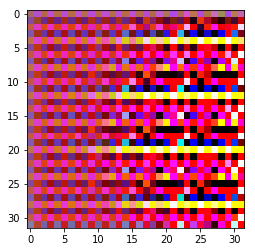

Estimate: [[-0.02556928]]
0.705995 0.680603
Iteration: 11000 at 2018-04-16 05:38:21.019171


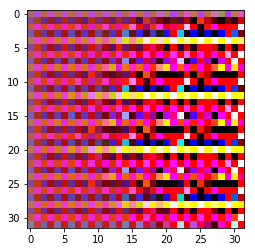

Estimate: [[-0.02558476]]
0.706007 0.680595
Iteration: 11100 at 2018-04-16 05:41:19.048727


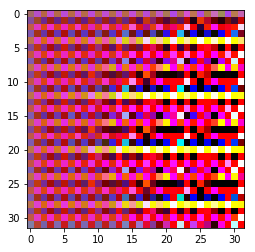

Estimate: [[-0.02578751]]
0.706093 0.680496
Iteration: 11200 at 2018-04-16 05:44:19.822370


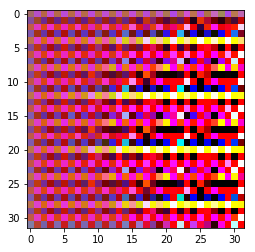

Estimate: [[-0.02580053]]
0.706116 0.680489
Iteration: 11300 at 2018-04-16 05:47:22.640434


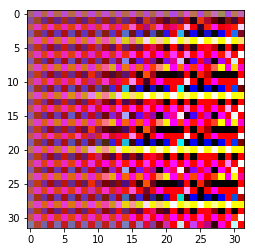

Estimate: [[-0.02603034]]
0.706192 0.680376
Iteration: 11400 at 2018-04-16 05:50:24.906341


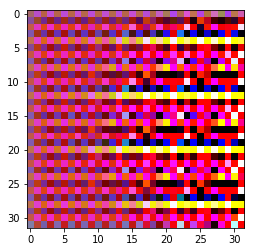

Estimate: [[-0.02624499]]
0.70629 0.680276
Iteration: 11500 at 2018-04-16 05:53:30.433901


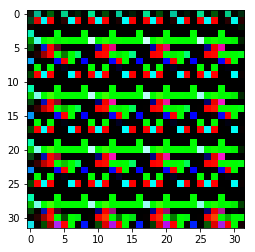

Estimate: [[-0.02518562]]
0.705933 0.681255
Iteration: 11600 at 2018-04-16 05:56:37.116217


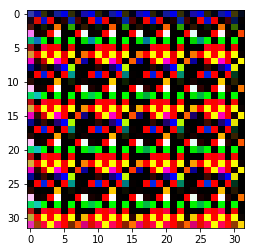

Estimate: [[-0.02445545]]
0.705282 0.681142
Iteration: 11700 at 2018-04-16 05:59:43.651650


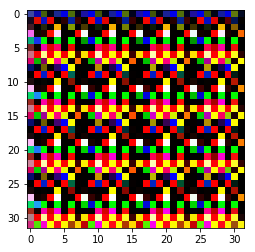

Estimate: [[-0.0240793]]
0.705261 0.681303
Iteration: 11800 at 2018-04-16 06:02:49.563935


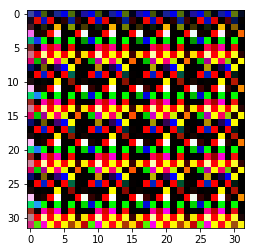

Estimate: [[-0.02412009]]
0.705281 0.681282
Iteration: 11900 at 2018-04-16 06:05:59.349702


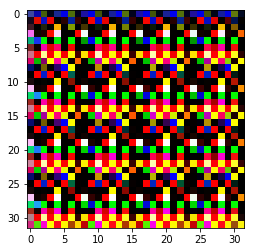

Estimate: [[-0.02427106]]
0.705356 0.681206
Iteration: 12000 at 2018-04-16 06:09:10.774647


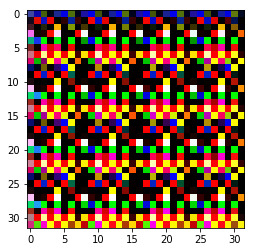

Estimate: [[-0.02426193]]
0.705347 0.68121
Iteration: 12100 at 2018-04-16 06:12:23.416449


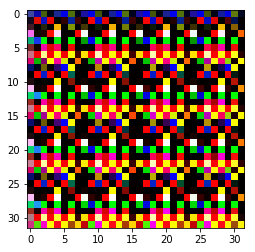

Estimate: [[-0.02439056]]
0.705414 0.681146
Iteration: 12200 at 2018-04-16 06:15:36.916049


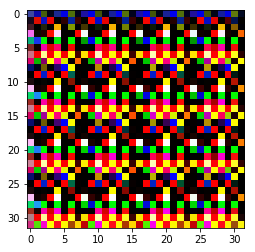

Estimate: [[-0.02437119]]
0.7054 0.681155
Iteration: 12300 at 2018-04-16 06:18:52.119453


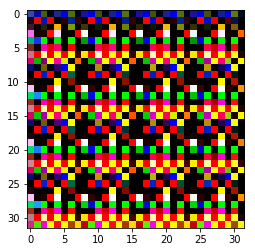

Estimate: [[-0.02449345]]
0.705464 0.681095
Iteration: 12400 at 2018-04-16 06:22:05.630025


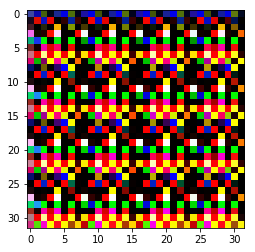

Estimate: [[-0.02447325]]
0.70545 0.681104
Iteration: 12500 at 2018-04-16 06:25:21.440430


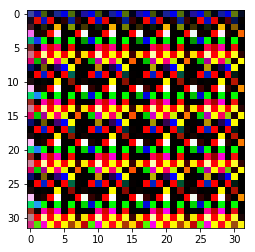

Estimate: [[-0.02459254]]
0.705512 0.681045
Iteration: 12600 at 2018-04-16 06:28:38.774415


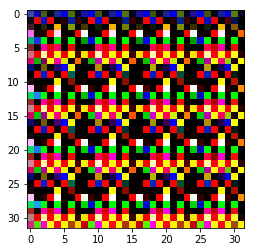

Estimate: [[-0.02456869]]
0.705497 0.681057
Iteration: 12700 at 2018-04-16 06:31:54.658028


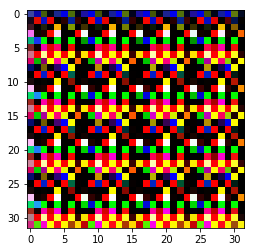

Estimate: [[-0.02468729]]
0.705558 0.680999
Iteration: 12800 at 2018-04-16 06:35:13.545318


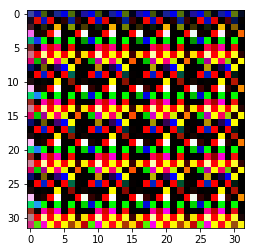

Estimate: [[-0.02466374]]
0.705545 0.68101
Iteration: 12900 at 2018-04-16 06:38:33.415211


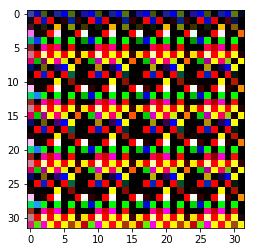

Estimate: [[-0.02478263]]
0.705603 0.680952
Iteration: 13000 at 2018-04-16 06:41:54.082606


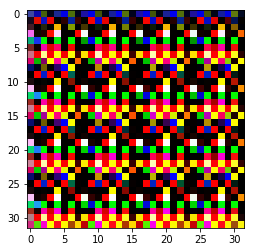

Estimate: [[-0.02475949]]
0.705593 0.680963
Iteration: 13100 at 2018-04-16 06:45:16.850531


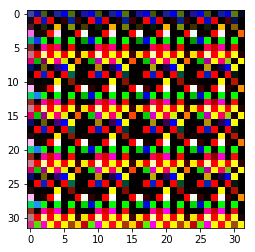

Estimate: [[-0.02487869]]
0.705647 0.680904
Iteration: 13200 at 2018-04-16 06:48:42.189001


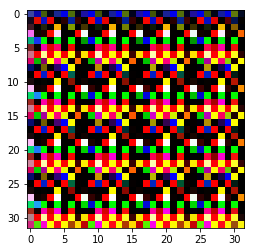

Estimate: [[-0.02485635]]
0.705642 0.680915
Iteration: 13300 at 2018-04-16 06:52:06.340557


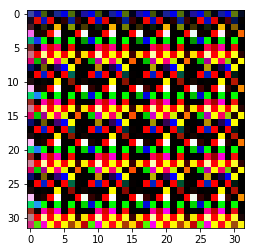

Estimate: [[-0.02497619]]
0.705692 0.680856
Iteration: 13400 at 2018-04-16 06:55:38.562936


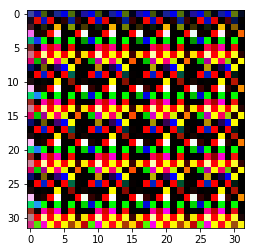

Estimate: [[-0.02495486]]
0.705692 0.680866
Iteration: 13500 at 2018-04-16 06:59:00.433818


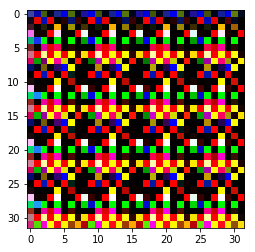

Estimate: [[-0.02496719]]
0.705738 0.680858
Iteration: 13600 at 2018-04-16 07:02:21.645720


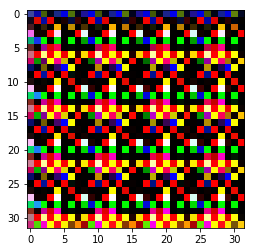

Estimate: [[-0.02505011]]
0.705741 0.680822
Iteration: 13700 at 2018-04-16 07:05:44.691969


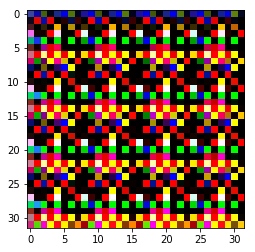

Estimate: [[-0.0253058]]
0.70582 0.680699
Iteration: 13800 at 2018-04-16 07:23:15.842232


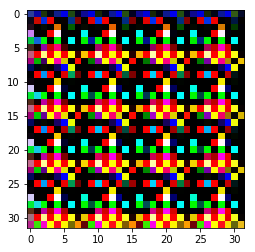

Estimate: [[-0.02424446]]
0.705871 0.681201
Iteration: 13900 at 2018-04-16 07:26:36.741975


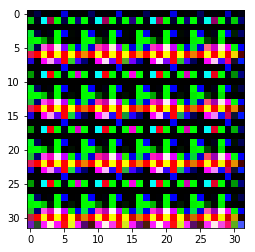

Estimate: [[-0.02748086]]
0.707028 0.679704
Iteration: 14000 at 2018-04-16 07:29:56.882299


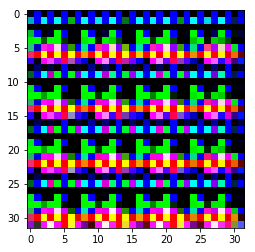

Estimate: [[-0.03111737]]
0.708587 0.677915
Iteration: 14100 at 2018-04-16 08:35:12.991507


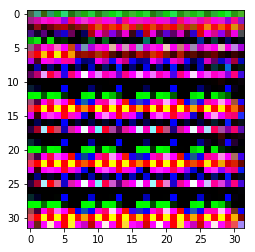

Estimate: [[-0.03291465]]
0.710757 0.677
Iteration: 14200 at 2018-04-16 08:45:03.004809


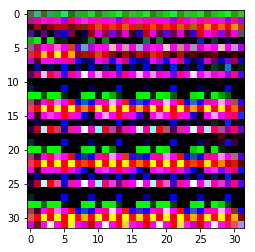

Estimate: [[-0.03384329]]
0.710194 0.676535
Iteration: 14300 at 2018-04-16 09:27:15.673033


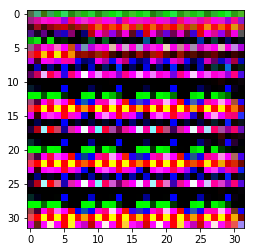

Estimate: [[-0.03455712]]
0.710602 0.676179
Iteration: 14400 at 2018-04-16 10:15:51.877573


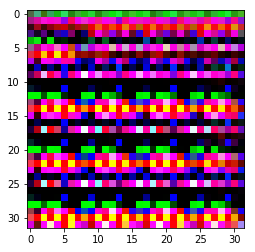

Estimate: [[-0.03487032]]
0.710719 0.676022
Iteration: 14500 at 2018-04-16 11:34:44.889339


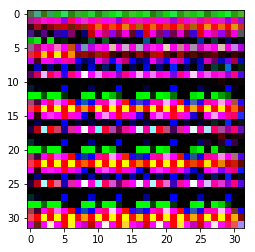

Estimate: [[-0.03524971]]
0.710933 0.675833
Iteration: 14600 at 2018-04-16 12:48:41.053580


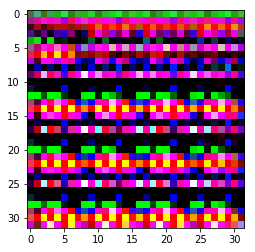

Estimate: [[-0.03536902]]
0.710974 0.675773
Iteration: 14700 at 2018-04-16 12:57:56.734796


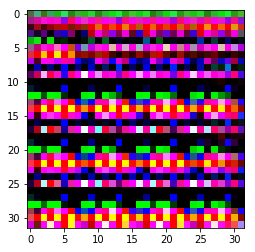

Estimate: [[-0.0356227]]
0.711113 0.675647
Iteration: 14800 at 2018-04-16 14:09:37.917014


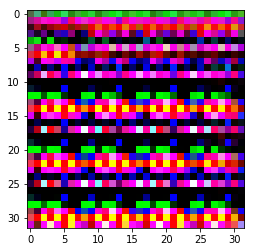

Estimate: [[-0.03566242]]
0.711124 0.675626
Iteration: 14900 at 2018-04-16 14:19:36.158346


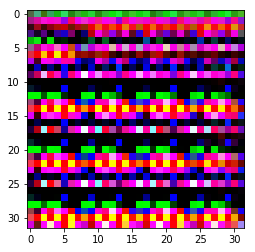

Estimate: [[-0.03585957]]
0.711225 0.675528
Iteration: 15000 at 2018-04-16 15:07:12.462994


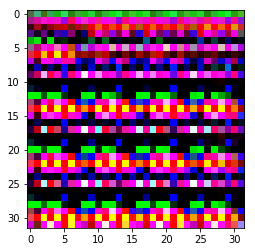

Estimate: [[-0.03586249]]
0.711226 0.675526
Iteration: 15100 at 2018-04-16 15:54:23.047310


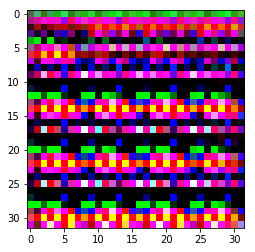

Estimate: [[-0.03603199]]
0.711308 0.675442
Iteration: 15200 at 2018-04-16 17:14:40.197096


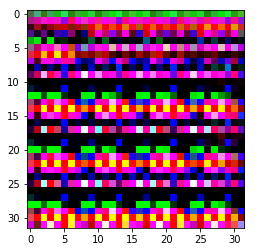

Estimate: [[-0.03601715]]
0.711305 0.675449
Iteration: 15300 at 2018-04-16 17:24:07.345248


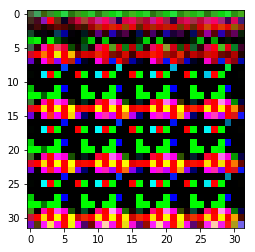

Estimate: [[-0.03491603]]
0.711375 0.676016
Iteration: 15400 at 2018-04-16 18:37:31.675587


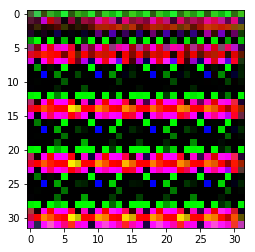

Estimate: [[-0.03616922]]
0.711389 0.675403
Iteration: 15500 at 2018-04-16 18:47:06.490471


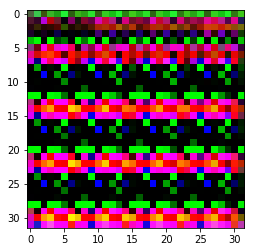

Estimate: [[-0.03636998]]
0.711496 0.675299
Iteration: 15600 at 2018-04-16 19:35:50.243462


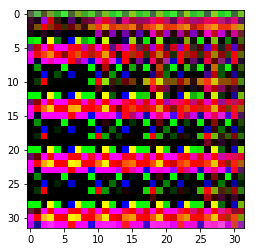

Estimate: [[-0.03626827]]
0.711439 0.675324
Iteration: 15700 at 2018-04-16 19:40:16.975704


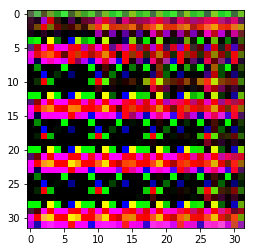

Estimate: [[-0.03641564]]
0.711556 0.675252
Iteration: 15800 at 2018-04-16 19:44:35.831045


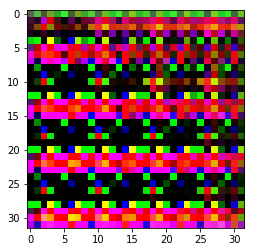

Estimate: [[-0.03638559]]
0.711493 0.675266
Iteration: 15900 at 2018-04-16 19:49:03.437755


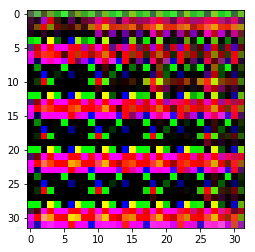

Estimate: [[-0.03652498]]
0.711591 0.675197
Iteration: 16000 at 2018-04-16 19:53:29.493323


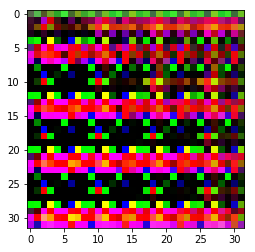

Estimate: [[-0.03648978]]
0.711547 0.675214
Iteration: 16100 at 2018-04-16 19:58:00.662690


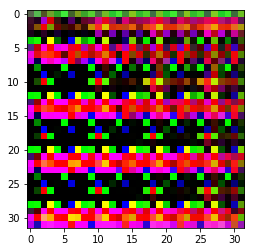

Estimate: [[-0.03662714]]
0.711633 0.675147
Iteration: 16200 at 2018-04-16 20:02:30.819513


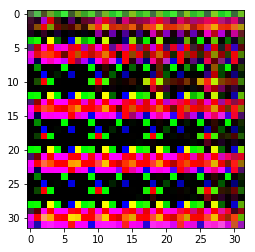

Estimate: [[-0.03659424]]
0.711599 0.675163
Iteration: 16300 at 2018-04-16 20:07:04.326186


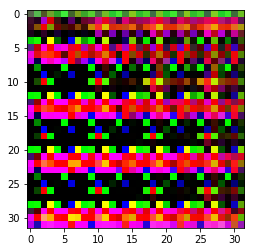

Estimate: [[-0.0367335]]
0.711677 0.675094
Iteration: 16400 at 2018-04-16 20:11:15.090708


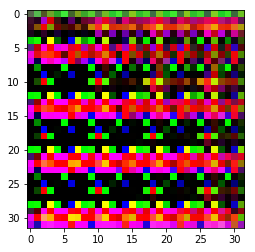

Estimate: [[-0.03669986]]
0.711653 0.675111
Iteration: 16500 at 2018-04-16 20:15:08.537991


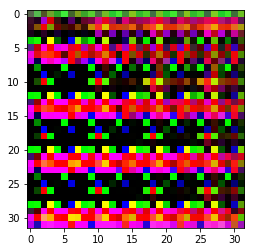

Estimate: [[-0.03684046]]
0.711724 0.675042
Iteration: 16600 at 2018-04-16 20:19:01.266736


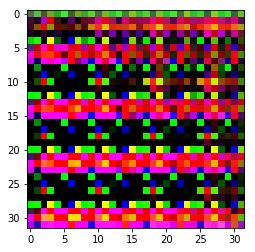

Estimate: [[-0.03681488]]
0.711708 0.675057
Iteration: 16700 at 2018-04-16 20:36:01.627072


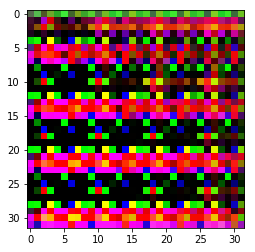

Estimate: [[-0.03694966]]
0.711771 0.674988
Iteration: 16800 at 2018-04-16 20:40:23.913964


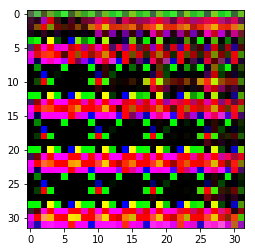

Estimate: [[-0.03691113]]
0.711764 0.675007
Iteration: 16900 at 2018-04-16 20:44:38.252059


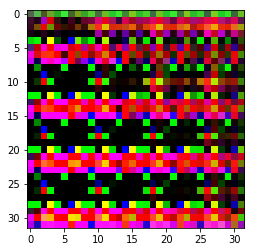

Estimate: [[-0.03705992]]
0.71182 0.674934
Iteration: 17000 at 2018-04-16 20:48:46.990963


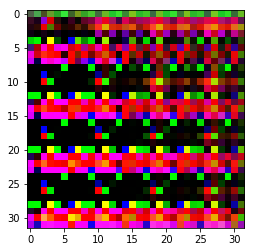

Estimate: [[-0.03719759]]
0.711867 0.674922
Iteration: 17100 at 2018-04-16 20:52:52.443472


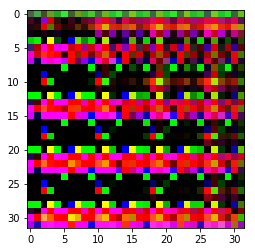

Estimate: [[-0.04261746]]
0.714629 0.672282
Iteration: 17200 at 2018-04-16 20:56:58.714796


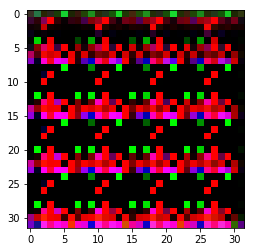

Estimate: [[-0.04311552]]
0.715178 0.672054
Iteration: 17300 at 2018-04-16 21:01:19.654841


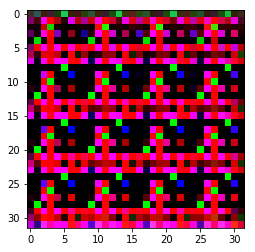

Estimate: [[-0.0500321]]
0.718444 0.66871
Iteration: 17400 at 2018-04-16 21:05:47.175141


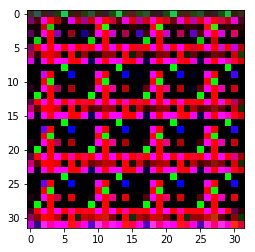

Estimate: [[-0.05324512]]
0.720092 0.667119
Iteration: 17500 at 2018-04-16 21:10:11.435240


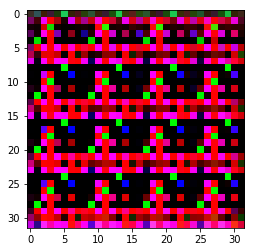

Estimate: [[-0.05497657]]
0.720986 0.666264
Iteration: 17600 at 2018-04-16 21:14:40.664012


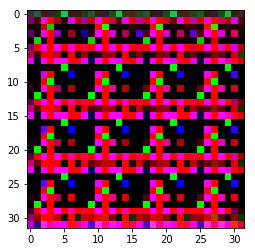

Estimate: [[-0.05574945]]
0.721387 0.665881
Iteration: 17700 at 2018-04-16 21:19:07.500382


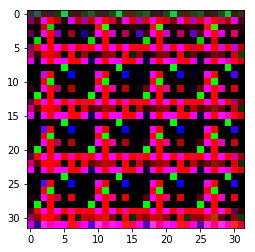

Estimate: [[-0.05643559]]
0.721726 0.665542
Iteration: 17800 at 2018-04-16 21:23:28.044784


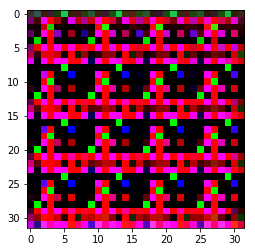

Estimate: [[-0.05667238]]
0.721864 0.665423
Iteration: 17900 at 2018-04-16 21:27:53.366893


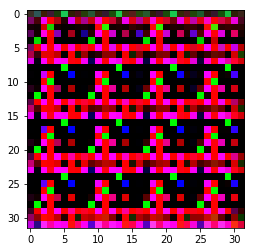

Estimate: [[-0.05704361]]
0.722027 0.665239
Iteration: 18000 at 2018-04-16 21:32:22.590431


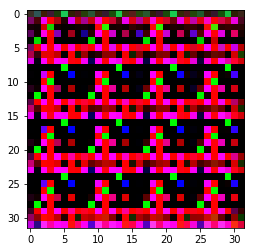

Estimate: [[-0.05709404]]
0.722082 0.665212
Iteration: 18100 at 2018-04-16 21:36:55.831063


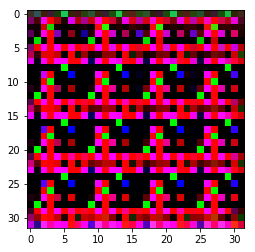

Estimate: [[-0.05734347]]
0.72217 0.665089
Iteration: 18200 at 2018-04-16 21:41:30.509670


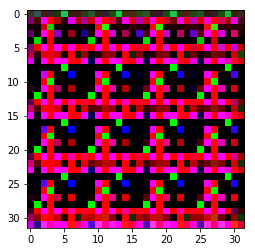

Estimate: [[-0.05731975]]
0.722199 0.665099
Iteration: 18300 at 2018-04-16 21:46:01.262251


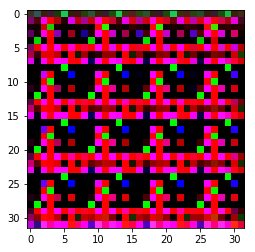

Estimate: [[-0.05751808]]
0.722249 0.665001
Iteration: 18400 at 2018-04-16 21:50:32.469377


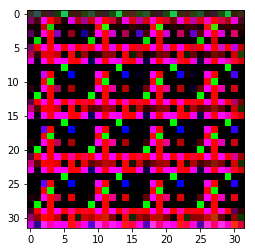

Estimate: [[-0.05746442]]
0.722274 0.665026
Iteration: 18500 at 2018-04-16 21:54:59.510043


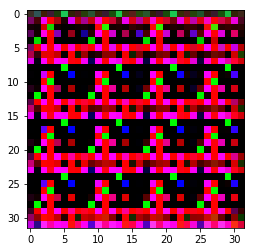

Estimate: [[-0.05764154]]
0.722303 0.664939
Iteration: 18600 at 2018-04-16 21:59:28.948752


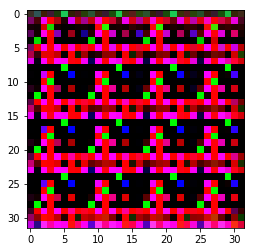

Estimate: [[-0.05757727]]
0.722332 0.664969
Iteration: 18700 at 2018-04-16 22:03:59.041617


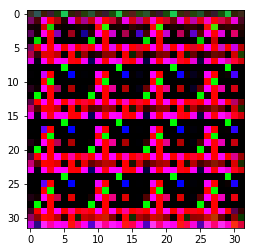

Estimate: [[-0.05775357]]
0.72235 0.664883
Iteration: 18800 at 2018-04-16 22:08:17.971607


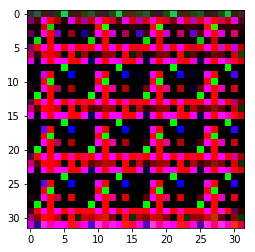

Estimate: [[-0.05770085]]
0.722396 0.664908
Iteration: 18900 at 2018-04-16 22:12:28.018491


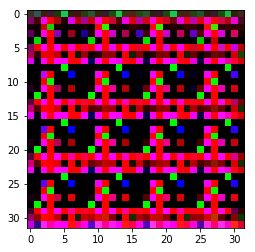

Estimate: [[-0.05788352]]
0.722408 0.664819
Iteration: 19000 at 2018-04-16 22:26:58.562219


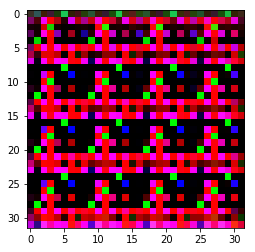

Estimate: [[-0.0578322]]
0.722464 0.664843
Iteration: 19100 at 2018-04-16 22:31:22.219974


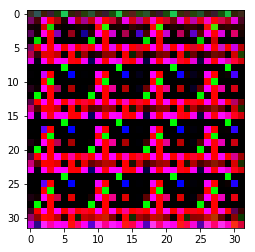

Estimate: [[-0.05801696]]
0.722469 0.664753
Iteration: 19200 at 2018-04-16 22:36:04.849338


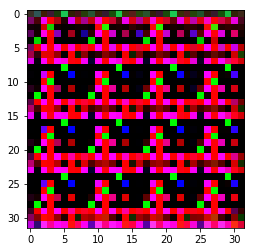

Estimate: [[-0.05796808]]
0.722534 0.664776
Iteration: 19300 at 2018-04-16 22:41:02.474345


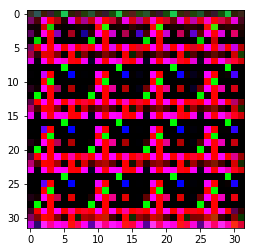

Estimate: [[-0.05815584]]
0.722531 0.664685
Iteration: 19400 at 2018-04-16 22:45:53.831641


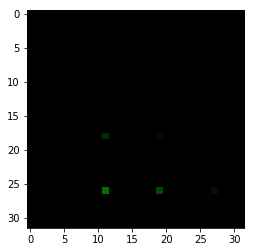

Estimate: [[-0.008729]]
0.721907 0.688926
Iteration: 19500 at 2018-04-16 22:50:37.621116


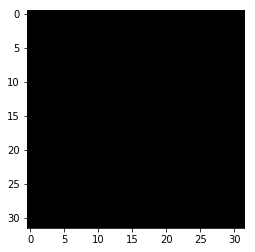

Estimate: [[-0.07544027]]
0.711856 0.656684
Iteration: 19600 at 2018-04-16 22:55:20.257382


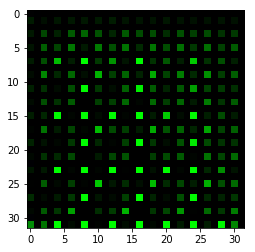

Estimate: [[-0.16587839]]
0.707227 0.614705
Iteration: 19700 at 2018-04-16 23:00:20.495461


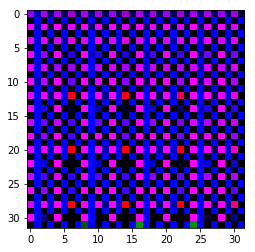

Estimate: [[-0.02887467]]
0.716173 0.679079


In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Pre-train discriminator
for i in range(300):
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    real_image_batch = x_train_reshape[i * batch_size % 10000: (i + 1) * batch_size % 10000]
    _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                           {x_placeholder: real_image_batch, z_placeholder: z_batch})

    if(i % 100 == 0):
        print("dLossReal:", dLossReal, "dLossFake:", dLossFake)

# Train generator and discriminator together

saver=tf.train.Saver(max_to_keep=1)
for i in range(50000):
    real_image_batch = x_train_reshape[i * batch_size % 10000: (i + 1) * batch_size % 10000]
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])

    # Train discriminator on both real and fake images
    _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                           {x_placeholder: real_image_batch, z_placeholder: z_batch})

    # Train generator
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    _ = sess.run(g_trainer, feed_dict={z_placeholder: z_batch})

    saver.save(sess,'ckpt/cifar.ckpt',global_step=i+1)
    if i % 10 == 0:
        # Update TensorBoard with summary statistics
        z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
        summary = sess.run(merged, {z_placeholder: z_batch, x_placeholder: real_image_batch})
        writer.add_summary(summary, i)

    if i % 100 == 0:
        # Every 100 iterations, show a generated image
        print("Iteration:", i, "at", datetime.datetime.now())
        z_batch = np.random.normal(0, 1, size=[1, z_dimensions])
        generated_images = generator(z_placeholder, 1, z_dimensions, reuse=True)
        images = sess.run(generated_images, {z_placeholder: z_batch})
        plt.imshow(images[0].reshape([32,32,3]))
        plt.show()

        # Show discriminator's estimate
        im = images[0].reshape([1, 32, 32, 3])
        result = discriminator(x_placeholder, reuse=True)
        estimate = sess.run(result, {x_placeholder: im})
        print("Estimate:", estimate)
        print(dLossReal, dLossFake)

 - Let's now see what a sample image looks like after training